In [66]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer, SimpleImputer

In [67]:
df = pd.read_csv("sources/CreditPrediction.csv")
df

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 19
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,NaN
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,NaN
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,NaN
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,NaN
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10162,718673358,35.0,M,3,Doctorate,NaN,$80K - $120K,Blue,30.0,5.0,3,4,13590.0,1528,0.728,2137,52,0.486,0.112,NaN
10163,715207458,46.0,F,1,Unknown,Single,Less than $40K,Blue,39.0,2.0,2,1,2029.0,1074,0.514,4802,90,0.800,0.529,NaN
10164,803665983,52.0,M,0,Unknown,NaN,$60K - $80K,Blue,46.0,3.0,2,4,2742.0,2184,0.592,3829,72,0.532,0.796,NaN
10165,713183508,39.0,F,1,High School,NaN,Unknown,NaN,36.0,1.0,3,2,2751.0,1158,0.821,4861,82,0.822,0.421,NaN


In [68]:
#Removing some Effectless
df = df.drop(['CLIENTNUM','Unnamed: 19', 'Total_Ct_Chng_Q4_Q1', 'Months_on_book', 'Education_Level', 'Marital_Status'], axis=1)

#calculate z-score 
z_score = pd.DataFrame()
z_score['Total_Trans_Amt'] = np.abs(stats.zscore(df['Total_Trans_Amt']))
outliers = list(np.where(np.abs(z_score['Total_Trans_Amt']) > 3)[0])
df = df.drop(df.index[outliers])

#convert Unknown datas to NaN
missing_values = ["NaN", "Unknown", ""]
df.replace(missing_values, np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9772 entries, 0 to 10166
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              9772 non-null   float64
 1   Gender                    9577 non-null   object 
 2   Dependent_count           9772 non-null   int64  
 3   Income_Category           8680 non-null   object 
 4   Card_Category             7922 non-null   object 
 5   Total_Relationship_Count  9753 non-null   float64
 6   Months_Inactive_12_mon    9772 non-null   int64  
 7   Contacts_Count_12_mon     9772 non-null   int64  
 8   Credit_Limit              9772 non-null   float64
 9   Total_Revolving_Bal       9772 non-null   int64  
 10  Total_Amt_Chng_Q4_Q1      9772 non-null   float64
 11  Total_Trans_Amt           9772 non-null   int64  
 12  Total_Trans_Ct            9772 non-null   int64  
 13  Avg_Utilization_Ratio     9772 non-null   float64
dtypes: float64(5

In [69]:
categorical_features = df.select_dtypes(include=['object']).columns
numeric_columns = df.select_dtypes(include=[float, int]).columns

#Encode Categorical datas
df['Income_Category'] = df['Income_Category'].map({"Less than $40K":0, "$40K - $60K":1, "$60K - $80K":2 ,"$80K - $120K":3, "$120K +":4})
df['Card_Category'] = df['Card_Category'].map({"Blue":0, "Silver":1, "Gold":2, "Platinum":3})
df['Gender'] = df['Gender'].map({"M":0, "F":1})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9772 entries, 0 to 10166
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              9772 non-null   float64
 1   Gender                    9577 non-null   float64
 2   Dependent_count           9772 non-null   int64  
 3   Income_Category           8680 non-null   float64
 4   Card_Category             7922 non-null   float64
 5   Total_Relationship_Count  9753 non-null   float64
 6   Months_Inactive_12_mon    9772 non-null   int64  
 7   Contacts_Count_12_mon     9772 non-null   int64  
 8   Credit_Limit              9772 non-null   float64
 9   Total_Revolving_Bal       9772 non-null   int64  
 10  Total_Amt_Chng_Q4_Q1      9772 non-null   float64
 11  Total_Trans_Amt           9772 non-null   int64  
 12  Total_Trans_Ct            9772 non-null   int64  
 13  Avg_Utilization_Ratio     9772 non-null   float64
dtypes: float64(8

In [ ]:
#EBLOW for analyze number of cluster

imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df)

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_imputed)
    silhouette_scores.append(silhouette_score(data_imputed, clusters))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('number of cluster')
plt.ylabel('Silhouette Score')
plt.title('')
plt.show()

In [73]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# مرحله 2: مقداردهی اولیه داده‌های مفقود با میانگین
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df)

# تبدیل داده‌های پر شده به DataFrame
df_imputed = pd.DataFrame(data_imputed, columns=df.columns)

# نمایش داده‌های پر شده با میانگین


# مرحله 3: اجرای الگوریتم K-means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_imputed) 

# اضافه کردن برچسب خوشه به داده‌ها
df_imputed['cluster'] = clusters



# مرحله 4: جایگزینی داده‌های مفقود
for feature in df.columns:
    if df[feature].isnull().any():
        for cluster in range(kmeans.n_clusters):
            # محاسبه میانگین ویژگی برای هر خوشه
            cluster_mean = df_imputed[df_imputed['cluster'] == cluster][feature].mean()
            # جایگزینی داده‌های مفقود با میانگین خوشه
            df_imputed.loc[(df_imputed['cluster'] == cluster) & (df[feature].isnull()), feature] = cluster_mean

# حذف ستون برچسب خوشه
df_final = df_imputed.drop(columns=['cluster'])

# نمایش داده‌های نها

df = df_final

In [74]:
#remove outliers (Q1, Q4)
def remove_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # حذف نقاط دورافتاده
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_clean = remove_outliers(df)

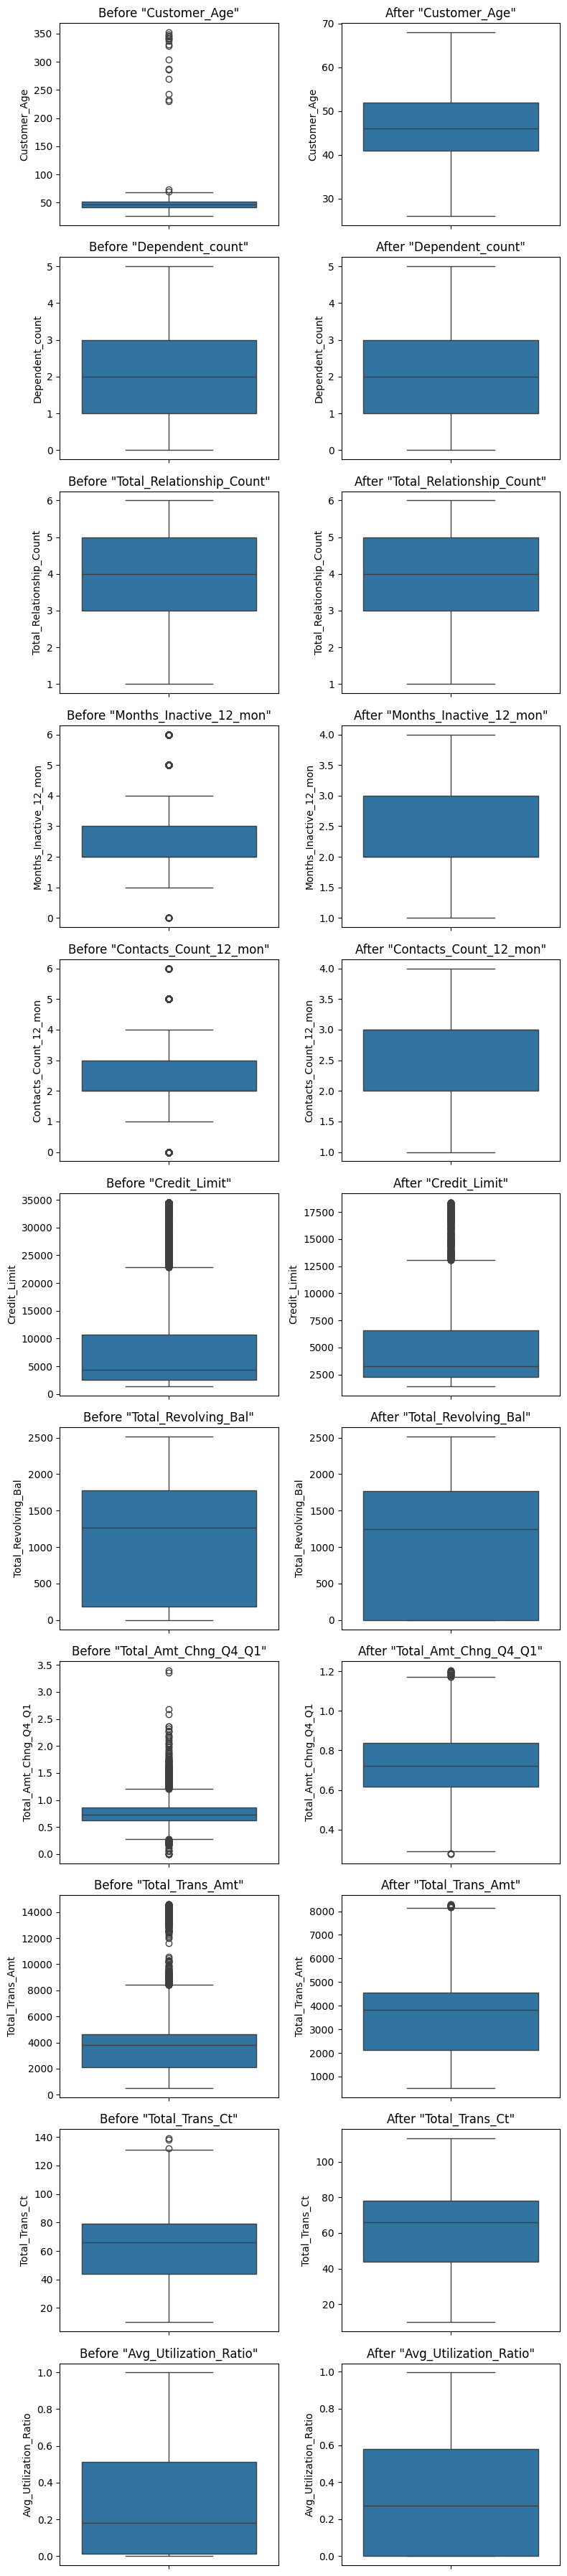

{0.0,
 0.10042435163886096,
 0.21230990533334196,
 0.40750539144390396,
 0.535031847133758,
 0.6869038631264421,
 1.0}

In [75]:
#show before and after of remove Q1, Q4
plt.figure(figsize=(8, 36))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 2, 2*i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Before "{column}"')
    plt.ylabel(column)
    
    plt.subplot(len(numeric_columns), 2, 2*i+2)
    sns.boxplot(y=df_clean[column])
    plt.title(f'After "{column}"')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

# df = df_clean
# df
set(df['Gender'])

In [76]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# مرحله 2: مقداردهی اولیه داده‌های مفقود با میانگین
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df)

# تبدیل داده‌های پر شده به DataFrame
df_imputed = pd.DataFrame(data_imputed, columns=df.columns)

# نمایش داده‌های پر شده با میانگین


# مرحله 3: اجرای الگوریتم K-means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_imputed) 

# اضافه کردن برچسب خوشه به داده‌ها
df_imputed['cluster'] = clusters



# مرحله 4: جایگزینی داده‌های مفقود
for feature in df.columns:
    if df[feature].isnull().any():
        for cluster in range(kmeans.n_clusters):
            # محاسبه میانگین ویژگی برای هر خوشه
            cluster_mean = df_imputed[df_imputed['cluster'] == cluster][feature].mean()
            # جایگزینی داده‌های مفقود با میانگین خوشه
            df_imputed.loc[(df_imputed['cluster'] == cluster) & (df[feature].isnull()), feature] = cluster_mean

# حذف ستون برچسب خوشه
df_final = df_imputed.drop(columns=['cluster'])

# نمایش داده‌های نها

df = df_final

{0.0,
 0.10042435163886096,
 0.21230990533334196,
 0.40750539144390396,
 0.535031847133758,
 0.6869038631264421,
 1.0}